# Classify Data Science Related Jobs on Indeed

In this project, I am going to use Web Scraping techniques to collect job posting data on Indeed.com, and then try to classify the job postings using Clustering based on the job descriptions.   

## Part 1: web scraping

I am going to get job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

In [1]:
base_url = "http://www.indeed.com"    

URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [2]:
import urllib
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import re

In [3]:
html = requests.get(URL)

# show a picture


While this has some more verbose elements removed, we can see that there is some structure to the above:

1. The title of a job is in a link with class set to jobtitle and a data-tn-element="jobTitle.
2. The location is set in a span with class='location'.
3. The company is set in a span with class='company'.

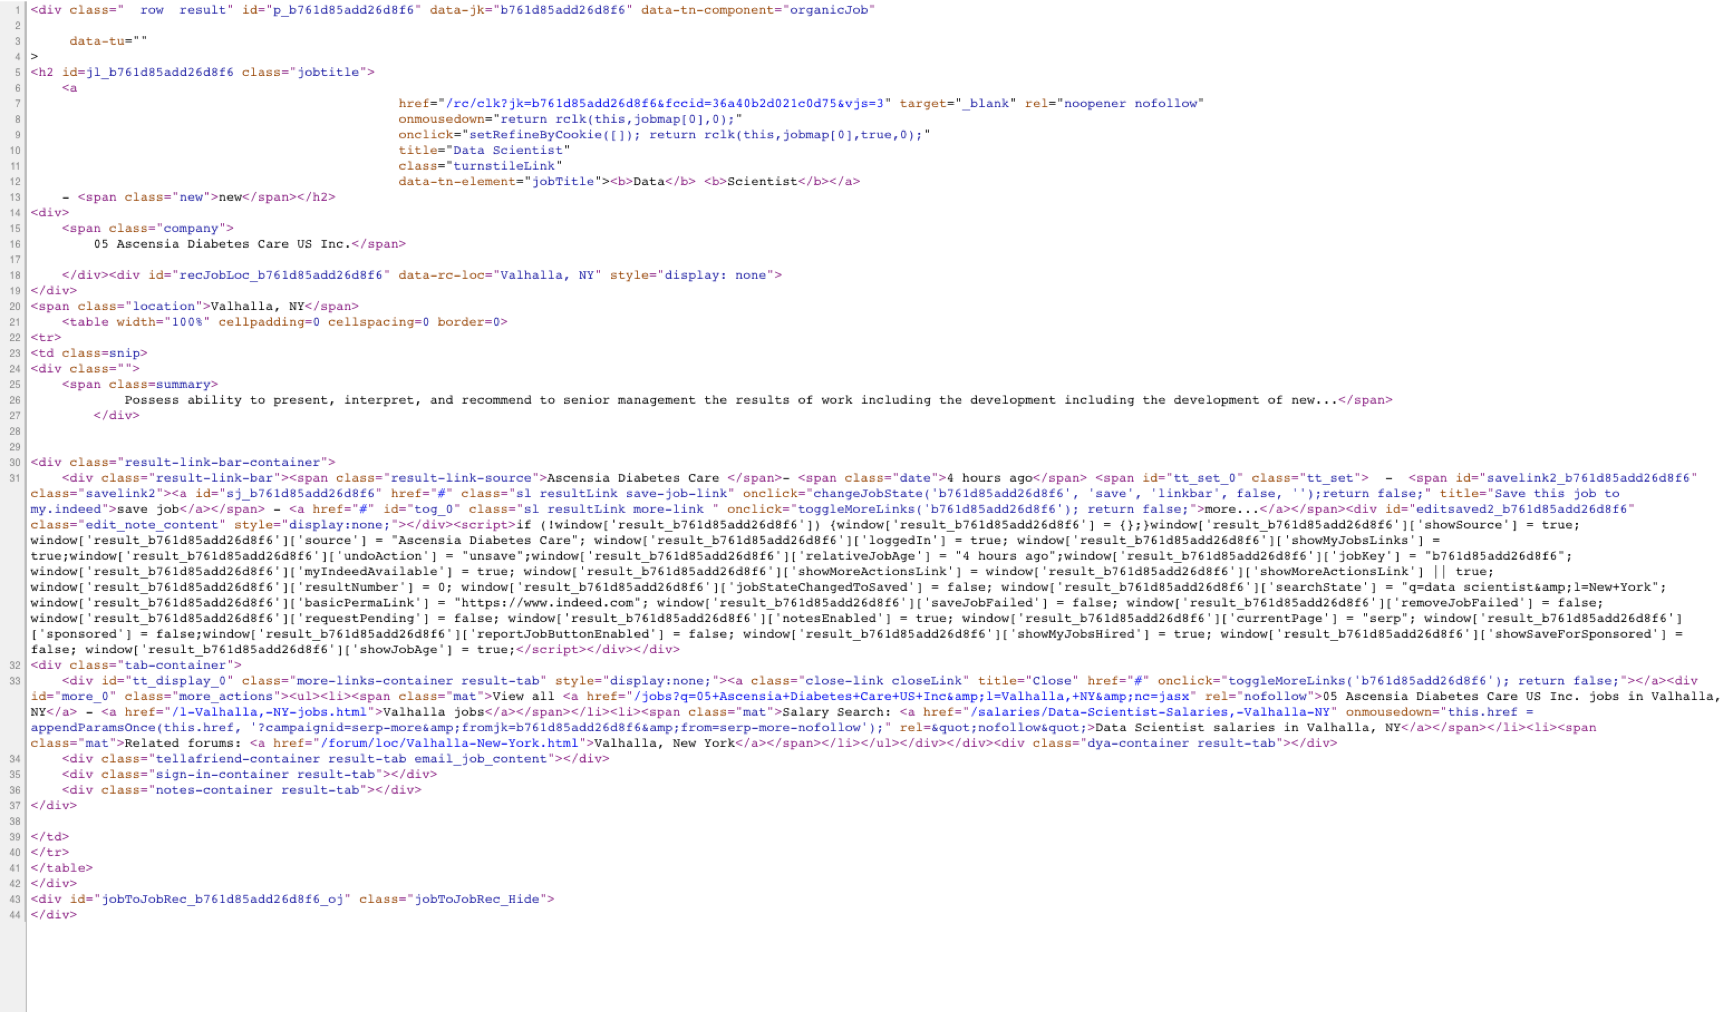

### Extract location, company, job title and summary of job posting


In [5]:

# urls = soup.findAll('a',{'rel':'nofollow','target':'_blank'}) #this are the links of the job posts
# urls = [link['href'] for link in urls] 
    
# print urls[0]


In [38]:
# function to get above information
df = pd.DataFrame(columns=["Title","Search","Location","Company", "detail_url"])

# search is the input term
def parse(url, df, search):
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")    
    for each in soup.find_all(class_= "result" ):
        try: 
            title = each.find(class_='jobtitle').text.replace('\n', '')
        except:
            title = 'None'
        try:
            location = each.find('span', {'class':"location" }).text.replace('\n', '')
        except:
            location = 'None'
        try: 
            company = each.find(class_='company').text.replace('\n', '')
        except:
            company = 'None'
        try:
            detail_url = each.a['href']
        except: 
            detail_url = 'None'
            
        df = df.append({'Title':title, "Search":search, 'Location':location, 'Company':company, 'detail_url':detail_url}, ignore_index=True)
    return df

In [7]:
parse(URL,df, "data scientist")

,Title,Search,Location,Company,Synopsis,detail_url
0,AI Research Scientist,data scientist,None,Bloomberg,The infrastructure...,/pagead/clk?mo=r&ad=-6NYlbfkN0Ab67y_gTDH9tSaT0...
1,"R&D Scientist, Jr.",data scientist,None,"Chembio Diagnostic Systems, Inc.",The Junior Scienti...,/pagead/clk?mo=r&ad=-6NYlbfkN0Bh1SHHOAOFytCJ6B...
2,"Research Scientist I - Extractable, Leachable ...",data scientist,None,Albany Molecular Research,Research Scientist...,/pagead/clk?mo=r&ad=-6NYlbfkN0D6lj-nm2lLlSIWTE...
3,"Senior Research Scientist - Extractable, Leach...",data scientist,None,Albany Molecular Research,Senior Research Sc...,/pagead/clk?mo=r&ad=-6NYlbfkN0D6lj-nm2lLlSIWTE...
4,Data Scientist,data scientist,"Manhattan, NY",Infomatics corp,We are seeking a Data Scientist. M...,/company/infomatics-corp/jobs/Data-Scientist-f...
5,Data Scientist,data scientist,"New York, NY",Global Recruitment Solutions,"Data science, data analysis, mining and analyz...",/company/Commericial-HVAC-&-Refrigeration-Cont...
6,Senior Data Scientist,data scientist,"New York, NY 10018 (Clinton area)",Octane Lending,We are seeking a talented data sci...,/rc/clk?jk=53d760b7b8278adc&fccid=3235588c6de4...
7,DATA SCIENTIST / ANALYST,data scientist,"New York, NY",Tangent Data Services,The candidate is expected to take ...,/rc/clk?jk=76447e24b89ff297&fccid=7340ed1d5880...
8,Junior Data Scientist,data scientist,"New York, NY 10176 (Murray Hill area)",Dow Jones,"Source, query, and clean data requ...",/rc/clk?jk=4769b53c33286f2e&fccid=d2621f51dde4...
9,Data Scientist,data scientist,"Manhattan, NY",NewYork-Presbyterian Hospital,Proficiency in data analytics and ...,/rc/clk?jk=c07a93d17aa5c592&fccid=4d5d694743c2...


#### filter ads and expand the data

In [94]:
import numpy as np
import pandas as pd
import nltk
import re
import os

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import lda

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

"http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"
There are two query parameters here we can alter to collect more results, the l=New+York and the start=10. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).




In [34]:
# create a template for changing search term, city and number of postings. 
# url_template.format(search, city, start)
url_template = "http://www.indeed.com/jobs?q={}&l={}&start={}"   
YOUR_CITY = 'Washington%2C+DC'
max_results_per_city = 100 # Set this to a high-value (5000) to generate more results. 
search_term = set(['Data+scientist', 'Machine+learning engineer', 'Data+analyst'])
cities = set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'San+Jose', YOUR_CITY])
# cities = set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
#     'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
#     'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', YOUR_CITY, 
#     'Charlottesville', 'Richmond', 'Baltimore', 'Harrisonburg', 'San+Antonio', 'San+Diego', 'San+Jose'
#     'Austin', 'Jacksonville', 'Indianapolis', 'Columbus', 'Fort+Worth', 'Charlotte', 'Detroit', 'El+Paso', 
#     'Memphis', 'Boston', 'Nashville', 'Louisville', 'Milwaukee', 'Las+Vegas', 'Albuquerque', 'Tucson', 
#     'Fresno', 'Sacramento', 'Long+Beach', 'Mesa', 'Virginia+Beach', 'Norfolk', 'Atlanta', 'Colorado+Springs',
#     'Raleigh', 'Omaha', 'Oakland', 'Tulsa', 'Minneapolis', 'Cleveland', 'Wichita', 'Arlington', 'New+Orleans', 
#     'Bakersfield', 'Tampa', 'Honolulu', 'Anaheim', 'Aurora', 'Santa+Ana', 'Riverside', 'Corpus+Christi', 'Pittsburgh', 
#     'Lexington', 'Anchorage', 'Cincinnati', 'Baton+Rouge', 'Chesapeake', 'Alexandria', 'Fairfax', 'Herndon',
#     'Reston', 'Roanoke'])

In [39]:
df_more = pd.DataFrame(columns=["Title","Search","Location","Company", "detail_url"])

for search in search_term:
    for city in cities:
        print search + ' '+ city
        for start in range(0, max_results_per_city, 10):
            url = url_template.format(search, city, start)
            df_more = parse(url,df_more, search)

Data+scientist Chicago
Data+scientist San+Francisco
Data+scientist New+York
Data+scientist Philadelphia
Data+scientist Los+Angeles
Data+scientist San+Jose
Data+scientist Atlanta
Data+scientist Seattle
Data+scientist Austin
Data+scientist Washington%2C+DC
Machine+learning engineer Chicago
Machine+learning engineer San+Francisco
Machine+learning engineer New+York
Machine+learning engineer Philadelphia
Machine+learning engineer Los+Angeles
Machine+learning engineer San+Jose
Machine+learning engineer Atlanta
Machine+learning engineer Seattle
Machine+learning engineer Austin
Machine+learning engineer Washington%2C+DC
Data+analyst Chicago
Data+analyst San+Francisco
Data+analyst New+York
Data+analyst Philadelphia
Data+analyst Los+Angeles
Data+analyst San+Jose
Data+analyst Atlanta
Data+analyst Seattle
Data+analyst Austin
Data+analyst Washington%2C+DC


In [40]:
print df_more.shape
df_more.head(100)

(4685, 5)


,Title,Search,Location,Company,detail_url
0,Data Scientist,Data+scientist,None,Crowe,/pagead/clk?mo=r&ad=-6NYlbfkN0BQvOTOov-yBJz3LQ...
1,Senior Data Scientist,Data+scientist,None,Trunk Club,/pagead/clk?mo=r&ad=-6NYlbfkN0CX1yD3h2XTR13aHG...
2,Data Scientist - Artificial Intelligence,Data+scientist,None,Ulta Beauty,/pagead/clk?mo=r&ad=-6NYlbfkN0DoaQv6kN82qMZPLI...
3,DATA SCIENTIST,Data+scientist,None,Trading Technologies,/pagead/clk?mo=r&ad=-6NYlbfkN0CGPPBhaIjKpVsWx8...
4,Data Scientist,Data+scientist,"Chicago, IL",Synchrony,/rc/clk?jk=619f469f4881f114&fccid=bfac37d9f1a8...
5,FBI Intelligence Analyst,Data+scientist,"Chicago, IL",Federal Bureau of Investigation,/company/Federal-Bureau-of-Investigation/jobs/...
6,Data Scientist,Data+scientist,"Chicago, IL",Trunk Club,/rc/clk?jk=993c4712bb3a0a52&fccid=0071370f02db...
7,"Data Scientist, Customer Insights",Data+scientist,"Chicago, IL 60654 (Loop area)",Groupon,/rc/clk?jk=4299d0cb3d242cb8&fccid=863ad2cc91c9...
8,Credit Audit Data Scientist & Analyst,Data+scientist,"Chicago, IL",BMO Financial Group,/company/BMO-Harris-Bank/jobs/Credit-Audit-Dat...
9,Data Scientist,Data+scientist,"Chicago, IL 60606 (Loop area)",Numerator,/rc/clk?jk=97cbcb6aa8a53cf4&fccid=11f2ca9fb727...


In [42]:
df_more = df_more.dropna().drop_duplicates()
print('You have ' + str(df_more.shape[0]) + ' results. ' 


You have 4518 results. 4518 of these aren't rubbish.


,Title,Search,Location,Company,detail_url
count,4518,4518,4518,4518,4518
unique,1825,3,517,1711,4405
top,Data Scientist,Data+analyst,None,Amazon.com,/rc/clk?jk=71de6b416a7f820e&fccid=160efb82f246...
freq,454,1518,1685,100,3


In [45]:
df_more = df_more[~df_more['Location'].isin(['None'])]
print df_more.shape
df_more.describe()

(2833, 5)


,Title,Search,Location,Company,detail_url
count,2833,2833,2833,2833,2833
unique,1723,3,516,1618,2720
top,Data Scientist,Machine+learning engineer,"Austin, TX",Amazon.com,/rc/clk?jk=619f469f4881f114&fccid=bfac37d9f1a8...
freq,296,964,200,100,3


In [74]:
df_more.shape

(2833, 7)

### read url

In [59]:
# save useful job description into a list
def parse_jd(url):
    jd = 'None'
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
    for each in soup.find_all(class_="jobsearch-JobComponent-description icl-u-xs-mt--md"):        
        jd =  each.text.replace('\n', '')
    return jd

In [60]:
url_detail = df_more['detail_url']
summary = []
check_progress = 0
for url in url_detail:
    if check_progress%50 == 0:
        print check_progress 
    check_progress += 1
    url_new = base_url + url
    try:
        s = parse_jd(url_new)
        summary.append(s) 
    except: 
        continue
        
    


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800


In [80]:
print len(summary)
summary[0]

2833


u'Job Description:As a Data Scientist within Synchrony, these individual may have varied responsibilities including, but not limited to:Role Summaries:We are looking for candidates who are curious and passionate about developing innovative solutions and have experience in big data environments, computer programming, Hadoop, Spark, Python, SAS etc. The successful candidate will have excellent communication & project management skills, strong model development experience and good understanding of model risk. The role will be responsible for hands-on model development to support credit acquisition, account management and fraud detection process.The person in this role will be part of design, development and implementation of machine learning solutions including tasks such as problem definition, data acquisition, data exploration and feature generation, testing and researching approaches and finally the building of production quality code for implementation and deployment.Essential Respons

In [64]:
textfile = open('JD.txt', 'w')
check_progress = 0
for s in summary:
    #if check_progress%50 == 0:
        #print check_progress/50*('*') 
    check_progress += 1
    s = s.encode('utf-8')
    textfile.write(s + '\n')
    textfile.write('\n BREAKS HERE')
textfile.close()

read data from txt

In [69]:
job_description = open('JD.txt').read().split('\n BREAKS HERE')
print len(job_description)

2834


In [71]:
df_more.to_csv('Indeed_data.csv', encoding='utf-8')